In [1]:
import keras
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas
from keras import Sequential
from keras.layers import *
from keras.models import Model
import keras.backend as K
from keras.optimizers import SGD, Adam
from keras.callbacks import LearningRateScheduler
import keras.callbacks as callbacks

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


input1 = Missing image (Masked by cloud)

input2 = Referenced images (cloud-free)

### Implement Model

In [2]:
input1 = Input(shape=(400,400,1), name='input1')
input2 = Input(shape=(400,400,1), name='input2')
input3 = Input(shape=(400,400,1), name='input3')

conv_1 = Conv2D(30, (3, 3), padding='same')(input1)
conv_2 = Conv2D(30, (3, 3), padding='same')(input2)
conv_3 = Conv2D(60, (3, 3), padding='same')(input3)

concat_1_2 = concatenate([conv_1, conv_2], axis=-1)
concat_1_2 = Activation('relu')(concat_1_2)

# concat_1_2 = Dropout(0.5)(concat_1_2)

feature_3 = Conv2D(filters=20, kernel_size=(3, 3),padding='same')(concat_1_2)
feature_5 = Conv2D(filters=20, kernel_size=(5, 5),padding='same')(concat_1_2)
feature_7 = Conv2D(filters=20, kernel_size=(7, 7),padding='same')(concat_1_2)
feature_3_5_7 = concatenate([feature_3, feature_5, feature_7])
feature_3_5_7 = Activation('relu')(feature_3_5_7)

# feature_3_5_7 = Dropout(0.5)(feature_3_5_7)

sum0 = add([concat_1_2, feature_3_5_7])

conv1 = Conv2D(filters=60, kernel_size=(3,3), padding='same',activation='relu')(sum0)
conv2 = Conv2D(filters=60, kernel_size=(3,3), padding='same',activation='relu')(conv1)

sum1 = add([conv2, conv_3])
conv3 = Conv2D(filters=60, kernel_size=(3,3), dilation_rate=2, padding='same',activation='relu')(sum1)
conv4 = Conv2D(filters=60, kernel_size=(3,3), dilation_rate=3, padding='same',activation='relu')(conv3)
conv5 = Conv2D(filters=60, kernel_size=(3,3), dilation_rate=2, padding='same',activation='relu')(conv4)
sum2 = add([conv5, conv_3])

conv6 = Conv2D(filters=60, kernel_size=(3,3), padding='same',activation='relu')(sum2)
# conv6 = Dropout(0.5)(conv6)

conv6_2 = add([conv6, conv1])

conv7 = Conv2D(filters=1, kernel_size=(3,3), padding='same')(conv6_2)

model = Model([input1, input2, input3], conv7)
    

#### Define PSNR Loss Metrics, remains loss function MSE ; Step Decay for Callbacks

In [3]:
def PSNRLoss(y_true, y_pred):
    return -10. * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.)

In [4]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.3
    epochs_drop = 5
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

## Read dataset

In [2]:
import h5py

f = h5py.File('small_train.hdf5', 'r')
trainY = f['label'][:]
trainX_1 = f['masked'][:]
trainX_2 = f['ref'][:]
trainX_3 = f['mask'][:]
f.close()


f = h5py.File('small_test.hdf5', 'r')
testY = f['label'][:]
testX_1 = f['masked'][:]
testX_2 = f['ref'][:]
testX_3 = f['mask'][:]
f.close()

In [3]:
trainX_3[:,:,:] = (765 - trainX_3[:,:,:])
trainX_3[:,:,:] = trainX_3[:,:,:] // 765
trainX_3 = abs(trainX_3)

In [4]:
testX_3[:,:,:] = (765 - testX_3[:,:,:])
testX_3[:,:,:] = testX_3[:,:,:] // 765
testX_3 = abs(testX_3)

### Config Model

In [9]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8) 
model.compile(optimizer=adam, loss='mean_squared_error', metrics=[PSNRLoss])

img_rows, img_cols = 400, 400
out_rows, out_cols = 400, 400

lrate = LearningRateScheduler(step_decay)
callback_list = [callbacks.ModelCheckpoint('weight.h5', monitor='val_PSNRLoss', save_best_only=True,
                                           mode='max', save_weights_only=True, verbose=2)]

In [10]:
trainX_3 = trainX_1 + np.multiply(trainX_2, np.reshape(trainX_3, (trainX_3.shape[0], img_rows, img_cols, 1)))

In [6]:
trainX_1.shape

(810, 400, 400, 1)

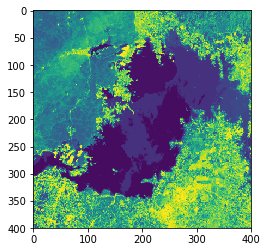

In [11]:
plt.imshow(trainX_3[0,:,:,0])

In [12]:
testX_3 = testX_1 + np.multiply(testX_2, np.reshape(testX_3, (testX_3.shape[0], img_rows, img_cols, 1)))

In [14]:
batch_size = 3
nb_epoch = 150

history = model.fit([trainX_1,trainX_2,trainX_3], trainY, batch_size=batch_size, epochs=nb_epoch, callbacks=callback_list,
                    verbose=1, validation_split=0.1)  

Train on 729 samples, validate on 81 samples
Epoch 1/150
729/729 [==============================] - 229s 314ms/step - loss: 0.0024 - PSNRLoss: 36.8607 - val_loss: 8.2773e-06 - val_PSNRLoss: 50.8211

Epoch 00001: val_PSNRLoss improved from -inf to 50.82109, saving model to weight.h5
Epoch 2/150
729/729 [==============================] - 226s 310ms/step - loss: 0.0017 - PSNRLoss: 37.5431 - val_loss: 5.6595e-06 - val_PSNRLoss: 52.4722

Epoch 00002: val_PSNRLoss improved from 50.82109 to 52.47221, saving model to weight.h5
Epoch 3/150
729/729 [==============================] - 225s 309ms/step - loss: 0.0025 - PSNRLoss: 34.8880 - val_loss: 4.3978e-05 - val_PSNRLoss: 43.5677

Epoch 00003: val_PSNRLoss did not improve from 52.47221
Epoch 4/150
729/729 [==============================] - 225s 309ms/step - loss: 0.0021 - PSNRLoss: 35.0867 - val_loss: 1.3461e-05 - val_PSNRLoss: 48.7091

Epoch 00004: val_PSNRLoss did not improve from 52.47221
Epoch 5/150
729/729 [==============================] - 

729/729 [==============================] - 224s 308ms/step - loss: 4.8079e-04 - PSNRLoss: 45.4294 - val_loss: 1.6736e-07 - val_PSNRLoss: 67.7635

Epoch 00076: val_PSNRLoss did not improve from 73.09293
Epoch 77/150
729/729 [==============================] - 224s 308ms/step - loss: 4.5852e-04 - PSNRLoss: 45.2007 - val_loss: 1.9058e-05 - val_PSNRLoss: 47.1992

Epoch 00077: val_PSNRLoss did not improve from 73.09293
Epoch 78/150
729/729 [==============================] - 224s 308ms/step - loss: 4.5540e-04 - PSNRLoss: 46.1718 - val_loss: 9.8020e-08 - val_PSNRLoss: 70.0868

Epoch 00078: val_PSNRLoss did not improve from 73.09293
Epoch 79/150
729/729 [==============================] - 224s 308ms/step - loss: 4.3195e-04 - PSNRLoss: 46.1828 - val_loss: 5.5719e-07 - val_PSNRLoss: 62.5400

Epoch 00079: val_PSNRLoss did not improve from 73.09293
Epoch 80/150
729/729 [==============================] - 224s 308ms/step - loss: 6.7090e-04 - PSNRLoss: 43.8915 - val_loss: 1.7788e-04 - val_PSNRLoss: 37.

In [18]:
validation_value = model.evaluate(x=[testX_1, testX_2, testX_3], y=testY, batch_size=3)

540/540 [==============================] - 58s 108ms/step


In [20]:
validation_value

[0.0014325911390339267, 49.86601394017537]

In [21]:
y_pred = model.predict([testX_1[10:11], testX_2[10:11], testX_3[10:11]])

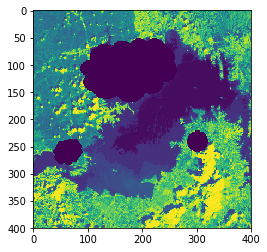

In [22]:
plt.imshow(testX_1[0,:,:,0])

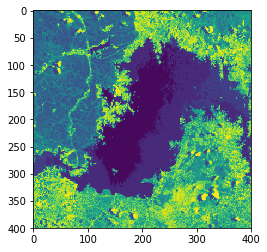

In [23]:
plt.imshow(testX_2[0,:,:,0])

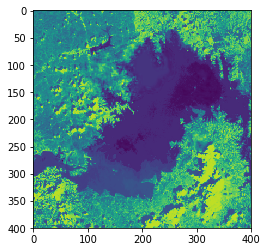

In [24]:
plt.imshow(y_pred[0,:,:,0])

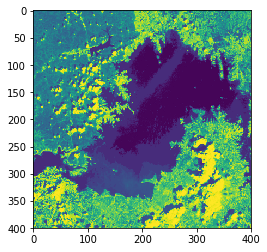

In [25]:
plt.imshow(testY[0,:,:,0])

In [26]:
print(history.history.keys())

dict_keys(['loss', 'PSNRLoss', 'val_PSNRLoss', 'val_loss'])


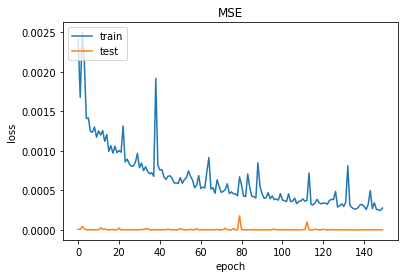

In [27]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

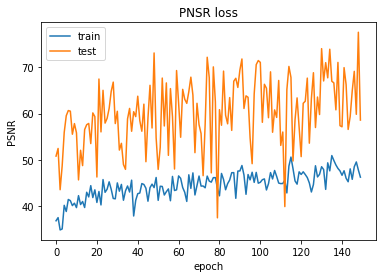

In [28]:
# summarize history for loss
plt.plot(history.history['PSNRLoss'])
plt.plot(history.history['val_PSNRLoss'])
plt.title('PNSR loss')
plt.ylabel('PSNR')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
model.save_weights('final_small_weight.h5')